In [ ]:
from scripts import helpers, mlogo


In [115]:
# Modules import
import os 
import pandas as pd
import numpy as np
from scripts import helpers
import pandas as pd
import matplotlib.pyplot as plt

# Class that generate motif-logo and perform data analysis on DNA sequences
class mlogo():
    """
    Class that generate motif-logo and perform data analysis on DNA sequences.
    The data can be grouped by the "group_by" argument (column) and generate 
    seperate plot for each subject 
    """

    def __init__(self,
                 seq_file,
                 group_by:str = None,
                 divide_subject:bool = True,
                 subject_col:str = "subject_id",
                 sequence_col:str = "sequence",
                 germline_col:str = "germline"):
        """
        seq_file : str -> file path / df object of sequencing data.
        group_by : str -> group the dataset by this column. will create number of subplots according
                          to the number of unique values in the grouped by column.
        divide_subject : bool -> Generate different plot for each subject under `subject_id` column.
        subject_col : str -> name of the subject column, defualt is `subject_id`. 
        sequence_col : str -> name of the DNA sequence column, defualt it `sequence`.
        germline_col : str -> name of the germline DNA sequence column, defualt it `germline`.
        """
        arguments_input = [group_by,
                           divide_subject,
                           subject_col,
                           sequence_col,
                           germline_col]
        self.init_dict = {i:j for i,j in zip(["group_by", "divide_subject", "subject_col", "sequence_col", "germline_col"], arguments_input)}
        
        
        # Loading sequences dataset
        try:
            if isinstance(seq_file, str):        
                self.seq_df = pd.read_csv(seq_file, index_col=0)
                print(f"> Dataset loaded (seq_file = '{seq_file}')")

            elif isinstance(seq_file, pd.DataFrame):
                 self.seq_df = seq_file
                 print("> Dataset loaded")

        except:
                print(f"> Invalid input, please make sure seq_file argument entred correctly.\n  (Invalid: seq_file = '{seq_file}')")

        # Translating germline and sequence DNA into amino acid sequence
        self.seq_df["sequence_aa"] = self.seq_df["sequence"].apply(helpers.nt_transalte_104) # Somatic sequence
        self.seq_df["germline_aa"] = self.seq_df["germline"].apply(helpers.nt_transalte_104) # Germline sequence
        

    def motif_logo(self,
                    aa_start: int = 1,
                    aa_end: int = -1):
            
            seq_list = self.seq_df["sequence_aa"].apply(lambda X : X[aa_start:aa_end])
            
            self.subplot_axidx = [0, 0]
            # Getting unique group by column values
            group_by_value = self.init_dict["group_by"]
            if isinstance(group_by_value, str): 
                 gp_unique = self.seq_df[group_by_value].unique()
                 self.subplot_axidx[0] = len(gp_unique)
                 cond_gp = [self.seq_df[group_by_value] == i for i in gp_unique]
            else:
                 cond_gp = np.full((self.seq_df.shape[0],1), True).flatten()

            # Getting subjects values
            subject_bool, subject_col = self.init_dict["divide_subject"], self.init_dict["subject_col"]
            subj_unique = self.seq_df[subject_col].unique()
            if subject_bool:
                 subj_len = len(subj_unique) 
                 self.subplot_axidx[1] = subj_len
                 cond_subj = [self.seq_df[subject_col] == i for i in subj_unique]
            else:
                 cond_subj = np.full((self.seq_df.shape[0],1), True).flatten()

            self.cond_matrix = (cond_gp, cond_subj)
            cond_idx = [[i,j] for i in range(0, self.subplot_axidx[1]) for j in self.subplot_axidx[0]]


            fig, axs = plt.subplots(ncols=self.subplot_axidx[0], 
                                    nrows=self.subplot_axidx[1])
            
            for ax, icond, idx,  in zip(axs, self.cond_matrix, cond_idx):
               print(idx)
            


            
            return 
             



In [116]:
# motif positions: 
seq_file = pd.read_csv("input\\cl_seqs_motif.csv")
test = mlogo(seq_file, 
             group_by="ab_target",
             divide_subject=True).motif_logo()

> Dataset loaded


TypeError: 'int' object is not iterable

In [108]:
test

[2, 5]

In [ ]:
# motif positions: 
seq_file = pd.read_csv("input\\cl_seqs_motif.csv")
test = mlogo(seq_file)

# Getting the relevent motif aa sequence (54-66): VAV ISYD..GSNK Y
seq_list = test.motif_logo(aa_start=52, aa_end=66)

> Dataset loaded


* Need the y-axis in bits
* We want to show
    - What to show the logo (all clones) of germline, somatic sp vs sn
    - Want somatic (only revelent motif) sp vs sn
    - per subject
      (1 per subject / 1 per time points (subjected koined) / grid (col -> ab,sn rows -> subjects))


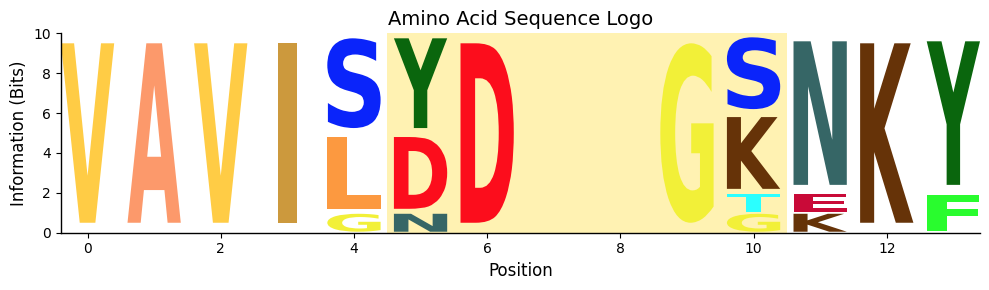

In [70]:
import logomaker
import pandas as pd
import matplotlib.pyplot as plt

# Creation of the sequences the Matrix, to_type='probability' are other options.
aligment_type = 'probability'
ww_df = logomaker.alignment_to_matrix(sequences=seq_list.values[:10], 
                                      to_type='counts', 
                                      pseudocount=0.0,
                                      characters_to_ignore=".-"
                                      )


info_df = logomaker.transform_matrix(
                                    ww_df, 
                                    from_type='counts', 
                                    to_type='information', 
                                    pseudocount=0.001
                                    )

# 3. Create the Logo
# We create a figure first to control the size
fig, ax = plt.subplots(figsize=(10, 3))

# Create the Logo object
logo = logomaker.Logo(ww_df,
                      color_scheme='skylign_protein', # 'chemistry' colors by property (polar, acidic, etc.)
                      vpad=.1,
                      width=.8,
                      ax=ax)

# 4. Style the Logo
logo.style_spines(visible=False)
logo.style_spines(spines=['left', 'bottom'], visible=True)
logo.ax.set_ylabel("Information (Bits)", fontsize=12)
logo.ax.set_xlabel("Position", fontsize=12)
logo.ax.set_title("Amino Acid Sequence Logo", fontsize=14)

# Optional: Highlight a specific region (e.g., residues 5-10)
logo.highlight_position_range(pmin=5, pmax=10, color='gold', alpha=0.3)

plt.tight_layout()
plt.show()